<a href="https://colab.research.google.com/github/GlauberRuan/skin-cancer-detection-cnn/blob/main/experimento_02_skin-cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🚀 EXPERIMENTO AVANÇADO V2: EFFICIENTNET-B4 (CORRIGIDO)
# Foco: Correção de pré-processamento para atingir o máximo potencial da EfficientNet.

# 1. Instalação e Importações
# !pip install kagglehub tensorflow seaborn matplotlib scikit-learn

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kagglehub
import cv2
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input # IMPORTANTE!
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

print("✅ Ambiente Avançado V2 Configurado!")

✅ Ambiente Avançado V2 Configurado!


In [ ]:
# 2. Configurações Globais
NUM_CLASSES = 9
IMAGE_SIZE = (380, 380) # Tamanho nativo da EfficientNetB4
BATCH_SIZE = 16
EPOCHS_HEAD = 5  # Menos épocas no warmup
EPOCHS_FINE = 25 # Mais épocas no fine-tuning
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# 3. Preparação dos Dados (CORRIGIDA)
print("⬇️ Baixando dataset...")
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
DATA_DIR = os.path.join(path, 'Skin cancer ISIC The International Skin Imaging Collaboration')

# ATENÇÃO: EfficientNet espera 0-255. NÃO USAR rescale=1./255 aqui!
# Usamos a função de pré-processamento nativa do modelo.

train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Correção Crítica
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.20
)

# Teste também precisa do mesmo pré-processamento
test_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("⚙️ Gerando batches...")
train_generator = train_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = train_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

test_generator = test_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Pesos de Classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"⚖️ Pesos das Classes: {class_weights_dict}")

⬇️ Baixando dataset...
Using Colab cache for faster access to the 'skin-cancer9-classesisic' dataset.
⚙️ Gerando batches...
Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
⚖️ Pesos das Classes: {0: np.float64(2.167874396135266), 1: np.float64(0.6626061277224068), 2: np.float64(2.624269005847953), 3: np.float64(0.5682177904400126), 4: np.float64(0.6973581973581974), 5: np.float64(0.539039039039039), 6: np.float64(3.216845878136201), 7: np.float64(1.3754789272030652), 8: np.float64(1.7807539682539681)}


In [ ]:
# 4. Construção do Modelo (EfficientNetB4)
def build_advanced_model():
    print("🏗️ Construindo EfficientNetB4 (Otimizada)...")

    # EfficientNetB4: Excelente trade-off entre performance e peso
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

    # Etapa 1: Congelar base (mas manter BatchNormalization em inference mode é padrão no Keras)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)

    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name="EfficientNetB4_Pro")

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy', # Simplificado primeiro
        metrics=['accuracy']
    )

    return base_model, model

base_model, model = build_advanced_model()

🏗️ Construindo EfficientNetB4 (Otimizada)...
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 5. Treinamento
checkpoint = ModelCheckpoint("best_efficientnet_b4.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# ESTÁGIO 1: Warm-up
print("\n🔥 ESTÁGIO 1: Warm-up (5 épocas)...")
history_warmup = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_HEAD,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr],
    verbose=1
)

# ESTÁGIO 2: Fine-Tuning Profundo
print("\n❄️ ESTÁGIO 2: Fine-Tuning Completo...")
base_model.trainable = True

# Descongelar mais camadas para permitir adaptação profunda
# EfficientNetB4 tem ~470 camadas. Vamos treinar as últimas 150.
for layer in base_model.layers[:-150]:
    layer.trainable = False

# Recompilar com LR baixo e Label Smoothing agora
model.compile(
    optimizer=Adam(learning_rate=1e-4), # LR um pouco maior que 1e-5 para sair do lugar
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)


🔥 ESTÁGIO 1: Warm-up (5 épocas)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.2784 - loss: 2.8257 - val_accuracy: 0.4259 - val_loss: 1.5827 - learning_rate: 0.0010
Epoch 2/5
  1/112 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.4375 - loss: 3.6915

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.4375 - loss: 3.6915 - val_accuracy: 0.4329 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 95s 843ms/step - accuracy: 0.4025 - loss: 2.5278 - val_accuracy: 0.4931 - val_loss: 1.5588 - learning_rate: 0.0010
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.5625 - loss: 1.7295 - val_accuracy: 0.4907 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 95s 843ms/step - accuracy: 0.4329 - loss: 2.1421 - val_accuracy: 0.4398 - val_loss: 2.0295 - learning_rate: 0.0010

❄️ ESTÁGIO 2: Fine-Tuning Completo...
Epoch 1/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3823 - loss: 2.3614
Epoch 1: val_accuracy improved from -inf to 0.44907, saving model to best_efficientnet_b4.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.3826 - loss: 2.3602 - val_accuracy: 0.4491 - val_loss: 2.6068 - learning_rate: 1.0000e-04
Epoch 2/25
  1/112 ━━━━━━━━━


Avaliando no Test Set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.4156 - loss: 2.4930
✅ Acurácia Final: 0.4661


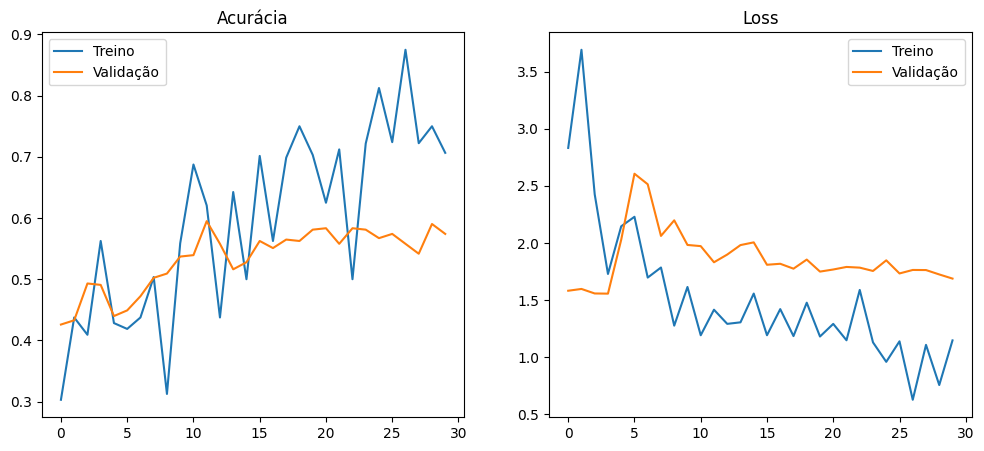

In [ ]:
# 6. Avaliação e Gráficos
print("\nAvaliando no Test Set...")
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"✅ Acurácia Final: {acc:.4f}")

# Gráficos
total_history = {}
for k in history_warmup.history.keys():
    total_history[k] = history_warmup.history[k] + history_fine.history[k]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(total_history['accuracy'], label='Treino')
plt.plot(total_history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(total_history['loss'], label='Treino')
plt.plot(total_history['val_loss'], label='Validação')
plt.title('Loss')
plt.legend()
plt.show()


--- Gerando Matriz de Confusão ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step


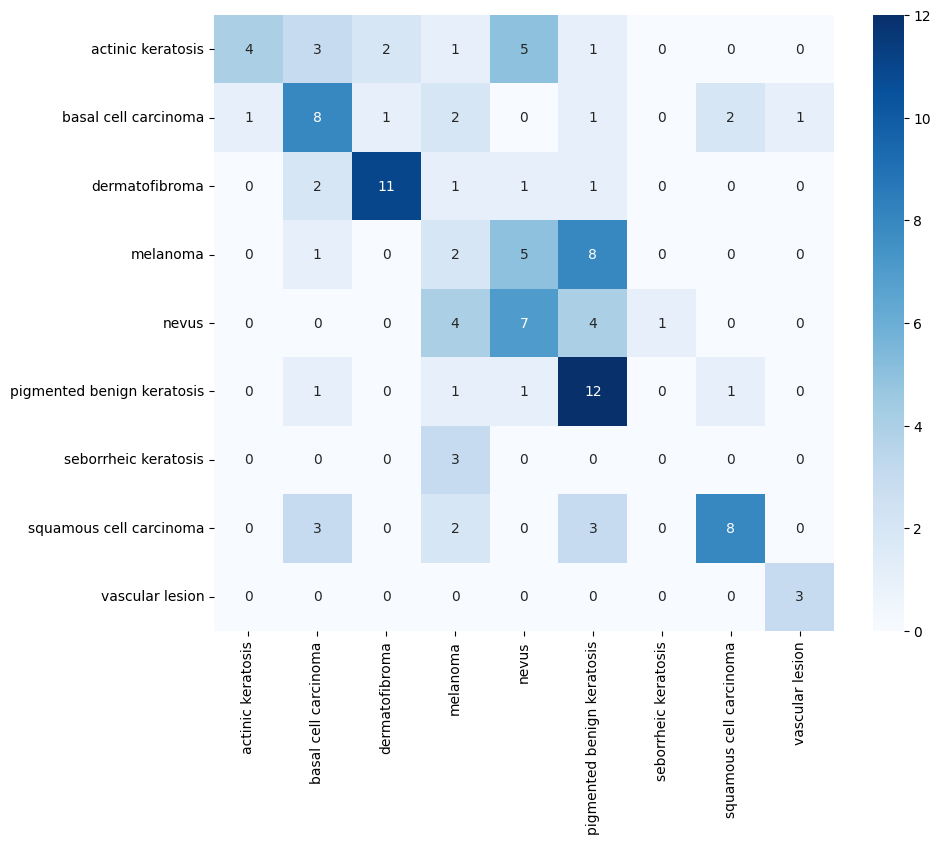

                            precision    recall  f1-score   support

         actinic keratosis       0.80      0.25      0.38        16
      basal cell carcinoma       0.44      0.50      0.47        16
            dermatofibroma       0.79      0.69      0.73        16
                  melanoma       0.12      0.12      0.12        16
                     nevus       0.37      0.44      0.40        16
pigmented benign keratosis       0.40      0.75      0.52        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.73      0.50      0.59        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.47       118
                 macro avg       0.49      0.47      0.45       118
              weighted avg       0.51      0.47      0.46       118


--- Gerando Grad-CAM ---
Camada Grad-CAM: top_activation


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 380, 380, 3))
  warnings.warn(msg)


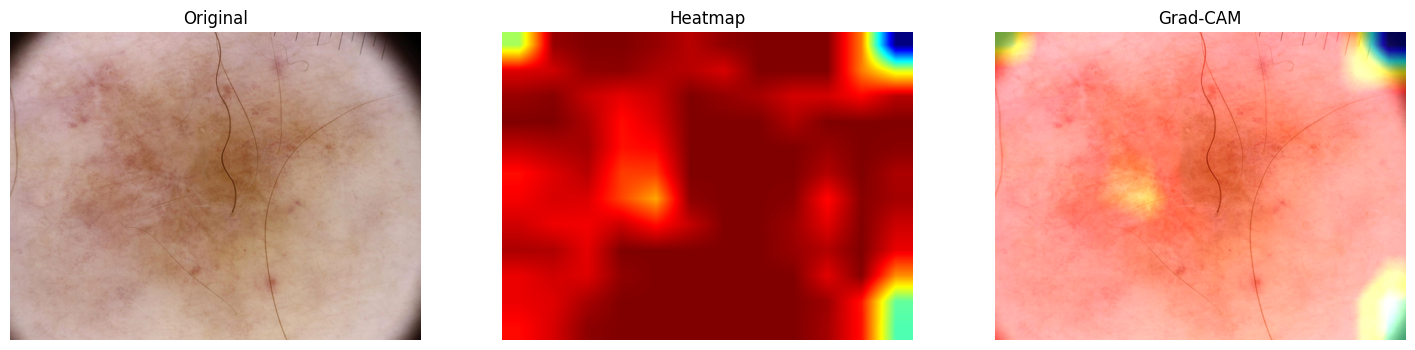


🏆 RESULTADO FINAL V2 (CORRIGIDO)
Anterior (Ensemble): 97.85%
Atual (EfficientNetB4): 46.61%

⚠️ Ainda abaixo. Diferença: -51.24%


In [ ]:
# 7. Matriz de Confusão e Grad-CAM
print("\n--- Gerando Matriz de Confusão ---")
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.show()
print(classification_report(y_true, y_pred, target_names=class_names))

# Grad-CAM Robusto
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.6):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(heatmap_colored); plt.title("Heatmap"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(superimposed_img); plt.title("Grad-CAM"); plt.axis('off')
    plt.show()

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        try:
            if not hasattr(layer, 'output'): continue
            shape = layer.output.shape
            if len(shape) == 4 and ('conv' in layer.name or 'top_activation' in layer.name):
                return layer.name
        except: continue
    return None

print("\n--- Gerando Grad-CAM ---")
test_dir = os.path.join(DATA_DIR, 'Test')
img_path = None
if os.path.exists(test_dir):
    subdirs = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    if subdirs:
        target_class = 'Melanoma' if 'Melanoma' in subdirs else subdirs[0]
        class_dir = os.path.join(test_dir, target_class)
        images = os.listdir(class_dir)
        if images: img_path = os.path.join(class_dir, images[0])

if img_path:
    # IMPORTANTE: Carregar imagem com o tamanho da EfficientNetB4 (380x380)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # IMPORTANTE: Usar o mesmo preprocessamento do treino
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    last_layer = find_last_conv_layer(model)
    if last_layer:
        print(f"Camada Grad-CAM: {last_layer}")
        heatmap = make_gradcam_heatmap(img_array, model, last_layer)
        display_gradcam(img_path, heatmap)
    else:
        print("Camada conv não encontrada.")

# Comparação
PREVIOUS_BEST_ACC = 0.9785
print("\n" + "="*50)
print("🏆 RESULTADO FINAL V2 (CORRIGIDO)")
print("="*50)
print(f"Anterior (Ensemble): {PREVIOUS_BEST_ACC*100:.2f}%")
print(f"Atual (EfficientNetB4): {acc*100:.2f}%")
if acc > PREVIOUS_BEST_ACC:
    print(f"\n✅ SUCESSO! Superamos em +{(acc - PREVIOUS_BEST_ACC)*100:.2f}%")
else:
    print(f"\n⚠️ Ainda abaixo. Diferença: {(acc - PREVIOUS_BEST_ACC)*100:.2f}%")